<div class="alert alert-block alert-info">
    <h1 align="center">Random Forest from scratch</h1>
    <h5 align="center">Mohammad Talaei (https://www.linkedin.com/in/mohammad-talaei-mt/)</h5>
</div>

> A basic from-scratch version of Random Forest.

Random Forest is a parallel ensembling algorithm in which each estimator (tree) receives different samples and features. This leads to different error distributions for each estimator which in turn makes the learning process more efficient and generalizable. The final prediction is the mean of all trees' predictions. The parallel nature of this algorithm makes it super fast in comparison with boosting algorithms like XGBoost.

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

## Tree Ensemble Class

In this section, we need to develop the Bagging (Bootstrap Aggregation) Ensembling algorithm. The key point is that we do not need to implement the Decision Tree at this stage. We assume that we already have it, and we focus on the ensembling class. Here, we only implemented subsampling among different RF parameters.

In [2]:
class TreeEnsemble():
    def __init__(self,x,y,n_trees,sample_sz,min_leaf=5):
        np.random.seed(42)
        self.x,self.y=x.reset_index().drop(['index'],axis=1),y.reset_index().drop(['index'],axis=1)
        self.sample_sz,self.min_leaf = sample_sz,min_leaf
        self.trees=[self.create_tree() for i in range(n_trees)]
    def create_tree(self):
        rnd_idxs=np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs],
                            self.y.reindex(rnd_idxs),
                            idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
    def predict(self, x):
        # axis=0 will average it across the list
        return np.mean([t.predict(x) for t in self.trees], axis=0)
    
def std_agg(cnt,s1,s2): return math.sqrt(((s2/cnt) - (s1/cnt)**2))

## Decision Tree Class
For each tree, we find the features with better information gain (reducing entropy). To this end, we need to find optimal split points for each feature. There will be more descriptions for this section in the future.

In [3]:
class DecisionTree():
    def __init__(self,x,y, idxs=None,min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf=x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val= np.mean(y.to_numpy()[idxs])
        self.shir=y.isnull().sum()
        self.score= float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x= self.split_col
        lhs=np.nonzero(x<=self.split)[0]
        rhs=np.nonzero(x>self.split)[0]
        self.lhs=DecisionTree(self.x,self.y,self.idxs[lhs])
        self.rhs=DecisionTree(self.x,self.y,self.idxs[rhs])
    
    def find_better_split(self, var_idx):
        x, y= self.x.to_numpy()[self.idxs,var_idx], self.y.to_numpy()[self.idxs]
        sort_idx=np.argsort(x)
    
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt, rhs_sum, rhs_sum2 = self.n,  sort_y.sum(), (sort_y**2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 =  0, 0., 0.
    
        for i in range(0,self.n-self.min_leaf-1):
            xi, yi= sort_x[i], sort_y[i]
            rhs_cnt -=1; lhs_cnt += 1
            rhs_sum -= yi; lhs_sum += yi
            rhs_sum2-=yi**2; lhs_sum2 +=yi**2 
        
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue
            
            rhs_std= std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            lhs_std= std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            corr_score= rhs_std+lhs_std
            if corr_score< self.score:
                self.score, self.var_idx, self.split = corr_score, var_idx, xi    
            
    def predict(self,x): return np.array([self.predict_row(xi) for xi in x.to_numpy()])
    
    def predict_row(self,xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
    
    @property
    def is_leaf(self): return self.score== float('inf')
    
    def __repr__(self):
        s= f'n: {self.n}; val: {self.val}'
        if not self.is_leaf:
            s+= f'; score:{self.score}; split:{self.split}; var:{self.split_name}' 
        return s

In [6]:
plt.style.use('seaborn')
PATH_DATA = "./data/"
house = pd.read_csv(PATH_DATA + "boston_house_prices.csv", header=1)
x = house.drop(house.MEDV.name, axis=1)
y = house.MEDV
x_train, x_test, y_train, y_test = train_test_split(x,y,shuffle=True,random_state=101,test_size=0.3)

In [7]:
tree=TreeEnsemble(x_train, y_train,20,250); r2_score(y_test,tree.predict(x_test))

0.746876960824918

OK, 0.74, not so bad!

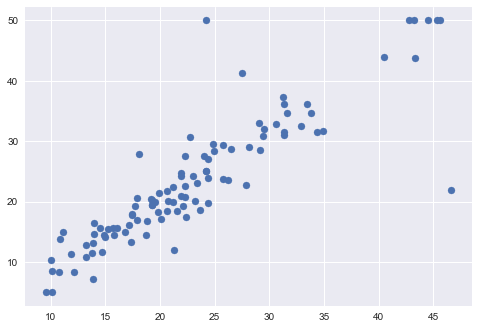

In [14]:
plt.scatter(tree.predict(x_test),y_test);

## Using Sklearn Random Forest
in order to compare models, we use the Random Forest of Scikit Learn library. 

In [8]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=20)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.8569015535244505

The result is evidently more accurate. The reason is that in the from_scratch version, we only implemented subsampling among different RF parameters. But the sklearn version is the complete version of Random Forest. We can implement more parameters to see the results.